## Setup

In [5]:
import os
root_dir = os.path.abspath('..')

In [138]:
import numpy as np
import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt
from scipy.misc import imresize, imrotate
%matplotlib inline

def fetch_data(base_dir,num_subjects):
    '''Load in simulated data and motion files.'''
    subject_list = os.listdir((os.path.join(base_dir)))
    subject_list = [item for item in subject_list if item.startswith('.') == False] #Filter .DS_STORE
    counter = 0
    X = np.zeros((108*num_subjects,72,86,55))
    y = np.zeros(108*num_subjects)
    X_subject = np.zeros((72,86,55,108))
    y_subject = np.zeros(108)
    for subject_index, subject_number in enumerate(subject_list):
        data_path = os.path.join(base_dir,subject_number,'data.nii.gz')
        if counter < num_subjects:
            if os.path.isfile(data_path):
                data_header = nib.load(data_path)
                X_subject = data_header.get_data()
                for i in range(108):
                    motion = np.loadtxt(os.path.join(base_dir,subject_number,'motion/motion'+str(i)+'.txt'))
                    y_subject[i] = create_labels(motion)
                start_index = counter*108
                end_index = (counter+1)*108
                X[start_index:end_index,:] = np.moveaxis(X_subject,3,0)
                y[start_index:end_index] = y_subject
                counter += 1
    return X,y

def create_labels(motion, translation_threshold=1, rotation_threshold = 1):
    '''Take a POSSUM motion file and decide whether it contains signficant intra-volume movement.'''
    max_motion = np.max(motion[:,1:],axis=0)
    min_motion = np.min(motion[:,1:],axis=0)
    diff_motion = np.abs(max_motion-min_motion)
    diff_motion[:3] = diff_motion[:3]*1000
    diff_motion[3:] = np.rad2deg(diff_motion[3:])
    if np.any( diff_motion[:3] > translation_threshold):
        return 1
    elif np.any(diff_motion[3:] > rotation_threshold):
        return 1
    else:
        return 0
    
def plot_volumes(X,y):
    X = np.moveaxis(X,0,3)
    num_volumes = 10
    plt.figure(figsize=(10,120))
    slices = [43,36,26]
    pad_max = np.max(X.shape[:3])
    for i in range(num_volumes):
        for j in range(3):
            plt.subplot(num_volumes,3,i*3+j+1)
            if j == 0:
                im = pad_image(np.squeeze(X[:,:,slices[j],i]),pad_max)
                plt.imshow(np.rot90(im),plt.cm.get_cmap('gray'))
                plt.title(y[i])
            if j == 1:
                im = pad_image(np.squeeze(X[:,slices[j],:,i]),pad_max)
                plt.imshow(np.rot90(im),plt.cm.get_cmap('gray'))
            if j == 2:
                im = pad_image(np.squeeze(X[slices[j],:,:,i]),pad_max)
                plt.imshow(np.rot90(im),plt.cm.get_cmap('gray'))
            plt.axis('off')
    plt.tight_layout()
                     
def pad_image(image,pad_max):
    if pad_max == 0:
        return image
    else:
        pad_width = np.array([[pad_max,pad_max],[pad_max,pad_max]])-[image.shape,image.shape]
        pad_width=np.transpose(pad_width)
        pad_width[:,0] = np.floor(pad_width[:,0]/2)
        pad_width[:,1] = np.ceil(pad_width[:,1]/2)
        return np.lib.pad(image,pad_width,'constant',constant_values=(0))



def preprocess_data_perp(X,target_height=299,target_width=299):
    '''Performs minimal pre-processing: convert each MR volume to a stack of 3 
    orthogonal planes, scale the data and resample to 299 by 299 pixels'''   
    slices = [26,36,26] #Planes to slice
    pad_max = np.max(X.shape[1:]) #Width to pad images to
    num_volumes = X.shape[0]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))
    for i in range(num_volumes):
        for j in range(3):
            if (j == 0):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,:,slices[j]]),pad_max),(target_width,target_height))
            if (j == 1):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))
            if (j == 2):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))     
                
    return X_preprocessed.astype(np.float32) / 255

def preprocess_data_planar(X,target_height=299,target_width=299,is_training=False,\
                           flip=False,rotate_z=False,sample_more_slices=True,pad_images=False,crop_image=False):
    '''Convert each MR volume to three slices through a single plane, scales the data and resamples
    to 299 by 299 pixels. Optionally performs augmentation.'''   
    #slices = [22,36,50] #Planes to slice
    slices = np.array([36,36,36]) #Planes to slice
    if pad_images == True:
        pad_max = np.max(X.shape[2:]) #Width to pad images to
    else:
        pad_max = 0
    num_volumes = X.shape[0]
    height = X.shape[1]
    width = X.shape[2]
    num_slices = X.shape[3]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))
    if is_training == True:
        for i in range(num_volumes):
            vol = np.copy(np.squeeze(X[i,:]))
            #Flip
            if flip == True:
                if np.random.uniform() > 0.5:
                    vol = np.fliplr(vol)
                if np.random.uniform() > 0.5:
                    vol = np.flip(vol,2)
            #Rotate about z
            if rotate_z == True:
                angle = np.random.randint(-20,20)
                for slice_num in range(num_slices):
                    vol[:,:,slice_num] = imrotate(vol[:,:,slice_num],angle,interp='bilinear')
            #Sample different slice in plane
            if sample_more_slices == True:
                slices_new = slices + np.random.randint(-5,5)
            else:
                slices_new = slices
            #Crop
            if crop_image == True:
                image_ratio = width / height
                target_image_ratio = target_width / target_height
                crop_vertically = image_ratio < target_image_ratio
                crop_width = width if crop_vertically else int(height * target_image_ratio)
                crop_height = int(width / target_image_ratio) if crop_vertically else height
                #Decrease size of bounding box to stop indexing errors
                crop_height -= 1
                crop_width -= 1

                # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
                # between 1.0 and 1.0 + `max_zoom`.
                #max_zoom = 0.8
                #resize_factor = np.random.rand() * max_zoom + 1.0
                #crop_width = int(crop_width / resize_factor)
                #crop_height = int(crop_height / resize_factor)

                # Next, we can select a random location on the image for this bounding box.
                x0 = np.random.randint(0, width - crop_width)
                y0 = np.random.randint(0, height - crop_height)
                
                x1 = x0 + crop_width
                y1 = y0 + crop_height
                print(x0,x1,y0,y1)
            else:
                x0=0;y0=0;x1=width;y1=height
            for j in range(3):
                if (j == 0):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(vol[slices_new[j],y0:y1, x0:x1],pad_max),(target_width,target_height))
                if (j == 1):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(vol[slices_new[j],y0:y1, x0:x1],pad_max),(target_width,target_height))
                if (j == 2):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(vol[slices_new[j],y0:y1, x0:x1],pad_max),(target_width,target_height))     
                    
    else:
        pad_max = np.max(X.shape[2:]) #Always pad for testing
        for i in range(num_volumes):
            for j in range(3):
                if (j == 0):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
                if (j == 1):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
                if (j == 2):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))     
                
    X_preprocessed = X_preprocessed.astype(np.float32)
    X_preprocessed/= 255
    X_preprocessed -= 0.5
    X_preprocessed *= 2.
    return X_preprocessed

14 85 0 71
0.0


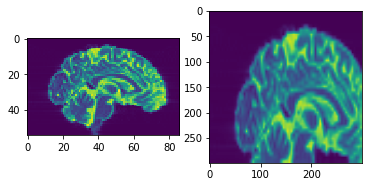

In [143]:
im =0
plt.subplot(1,2,1)
plt.imshow(np.rot90(X_train[im,36,:,:]));
X_train_preprocessed = preprocess_data_planar(X_train[0:1,:,:,:],is_training=True,sample_more_slices=False,\
                                              pad_images=False,crop_image=True)
plt.subplot(1,2,2)
plt.imshow(np.rot90(X_train_preprocessed[im,:,:,0])); plt.clim(-1,1)
print(y_train[im])

## Load in data

In [14]:
from sklearn.model_selection import train_test_split

X, y = fetch_data(os.path.join(root_dir,'data/sims'),8)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42) 
# X_train = X[:648]
# X_test = X[648:]
# y_train= y[:648]
# y_test=y[648:]

#Clear memory
del X,y 

0 108 (72, 86, 55, 108)
108 216 (72, 86, 55, 108)
216 324 (72, 86, 55, 108)
324 432 (72, 86, 55, 108)
432 540 (72, 86, 55, 108)
540 648 (72, 86, 55, 108)
648 756 (72, 86, 55, 108)
756 864 (72, 86, 55, 108)


## Train

In [ ]:
#Set up the inception v3 on data by stacking 3 perpendicular slices
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

num_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3),name="X") 
y = tf.placeholder(tf.int64, shape=(None), name="y")


with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)

#Define the scopes that you want to exclude for restoration
exclude = ['InceptionResnetV3/Logits', 'InceptionResnetV3/AuxLogits']
variables_to_restore = slim.get_variables_to_restore(exclude = exclude)
saver = tf.train.Saver(variables_to_restore)

with tf.Session() as sess:
    #saver.restore(sess,'models/inception_v3.ckpt');   
    last_layer = logits.op.inputs[0].op.inputs[0].op.inputs[0]
    last_layer_squeezed = tf.squeeze(last_layer,axis=[1,2])
    with tf.name_scope("output"):
        he_init = tf.contrib.layers.variance_scaling_initializer() #use the He initialisation scheme
        logits = fully_connected(last_layer_squeezed,num_outputs,activation_fn=None,weights_initializer = he_init,scope="logits")
        softmax_score = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
        loss = tf.reduce_mean(softmax_score,name="loss")
    with tf.name_scope("train"):
        #optimizer = tf.train.MomentumOptimizer(learning_rate=0.01,momentum=0.95)
        optimizer = tf.train.AdamOptimizer()
        #train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="InceptionV3/Mixed_7c/|logits")
        train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="logits")
        training_op = optimizer.minimize(loss,var_list=train_vars)
    with tf.name_scope("eval"):   
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        loss_summary = tf.summary.scalar('log_loss', loss)
    init = tf.global_variables_initializer()
    trained_saver = tf.train.Saver()
   

In [ ]:
#More set up
import time
from datetime import datetime

preprocess_function = preprocess_data_planar
X_test_preprocessed = preprocess_function(X_test)

num_epochs = 51
train_size = X_train.shape[0]
batch_size = 60
num_batches = np.floor(train_size / batch_size).astype(np.int16)

def get_batch(X,y,batch_size,batch_index):
    start_index = batch_index * batch_size
    end_index = (batch_index + 1) * batch_size
    return X[start_index:end_index,:], y[start_index:end_index]
    

In [9]:
#Train
warm_restart = False

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = 'tf_logs/trained_'+str(now)

with tf.Session() as sess:
    sess.run(init)
    if warm_restart == True:
        trained_saver.restore(sess,model_name)
    else:
        saver.restore(sess,'models/inception_v3.ckpt');
    file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())
    for epoch in range(num_epochs):
        t0=time.time()
        for index in range(num_batches):
            X_batch, y_batch = get_batch(X_train,y_train,batch_size,index)
            X_batch_preprocessed = preprocess_function(X_batch,is_training=True,crop_image=True)
            sess.run(training_op,feed_dict={X:X_batch_preprocessed,y:y_batch})
        #Test accuracy on roughly half of train set (for memory issues) and full test set 
        if epoch % 5 == 0:
            X_batch, y_batch = get_batch(X_train,y_train,400,0)    
            X_batch_preprocessed = preprocess_function(X_batch)
            acc_train,loss_train,loss_train_summary = sess.run([accuracy,loss,loss_summary],\
                                                               feed_dict={X: X_batch_preprocessed, y: y_batch})
            file_writer.add_summary(loss_train_summary, epoch)
            acc_test = accuracy.eval(feed_dict={X: X_test_preprocessed, y: y_test})
            t1=time.time()
            print('Epoch:',epoch,'train loss:',loss_train,"train acc:", acc_train,"val acc:", acc_test,"time:",t1-t0)
        else:
            t1=time.time()
            print('Epoch:',epoch,"time:",t1-t0) 
    print("Training finished.")
    print('Saving...')
    model_name = 'models/trained_'+str(now)
    save_path = trained_saver.save(sess,model_name)
    print('Model saved.')
    test_logits = logits.eval(feed_dict={X: X_test_preprocessed, y: y_test})

KeyboardInterrupt: 

In [12]:
#Loading back in
#model_name = 'models/trained_20170829135247'
with tf.Session() as sess:
    sess.run(init)
    trained_saver.restore(sess,model_name)
    test_logits = logits.eval(feed_dict={X: X_test_preprocessed, y: y_test})

INFO:tensorflow:Restoring parameters from models/trained_20170829135247


## Visualise

In [223]:
#Establish baseline for metrics
#Train accuracy if classified everything as 0:
print('Minimum train accuracy:',float((y_train.shape-sum(y_train))/y_train.shape))

#Ttest accuracy if classified everything as 0:
print('Minimum test  accuracy:',float((y_test.shape-sum(y_test))/y_test.shape))

Minimum train accuracy: 0.7484567901234568
Minimum test  accuracy: 0.7222222222222222


In [224]:
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import animation
from matplotlib import animation, rc
from IPython.display import HTML

probabilities = np.exp(test_logits)/np.sum(np.exp(test_logits),1,keepdims=True)
predictions = np.argmax(probabilities,1)
#Change threshold to alter sensitivity/specificity 
#predictions = probabilities[:,1] > 0.47 
print('Test  accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:','\n',confusion_matrix(y_test,predictions))

ind_true_pos = [indx for indx,y in enumerate(y_test) if (y_test[indx] == 1) and (predictions[indx] == 1) ]
ind_true_neg = [indx for indx,y in enumerate(y_test) if (y_test[indx] == 0) and (predictions[indx] == 0) ]
ind_false_neg = [indx for indx,y in enumerate(y_test) if (y_test[indx] == 1) and (predictions[indx] == 0) ]
ind_false_pos = [indx for indx,y in enumerate(y_test) if (y_test[indx] == 0) and (predictions[indx] == 1) ]

#print(probabilities[ind_true_neg,1])

Test  accuracy: 0.814814814815
Confusion matrix: 
 [[148   8]
 [ 32  28]]


In [225]:
#Animated plot of confusion-matrix
X_test_preprocessed_plot = X_test_preprocessed / 2
X_test_preprocessed_plot += 0.5

fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

image1 = ax1.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax1.axis('off')
image2 = ax2.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax2.axis('off')
image3 = ax3.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax3.axis('off')
image4 = ax4.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax4.axis('off')
fig.text(0.5, 0.94, 'Predictions', ha='center',weight='bold')
fig.text(0.06, 0.5, 'Actual', ha='center',weight='bold')
fig.text(0.08, 0.7, 'False', ha='center')
fig.text(0.08, 0.3, 'True', ha='center')
fig.text(0.32, 0.9, 'False', ha='center')
fig.text(0.7, 0.9, 'True', ha='center')
fig.text(0.47, 0.52, str(len(ind_true_neg)), ha='center',color='white')
fig.text(0.55, 0.52, str(len(ind_false_pos)), ha='center',color='white')
fig.text(0.47, 0.45, str(len(ind_false_neg)), ha='center',color='white')
fig.text(0.55, 0.45, str(len(ind_true_pos)), ha='center',color='white')

matplotlib.rcParams.update({'font.size': 20})
fig.subplots_adjust(hspace=0.03, wspace=0.02)
plt.close()

def init():
    image1.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2]))); 
    image2.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2])))
    image3.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2])))
    image4.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2])))
    
    return image1,image2,image3,image4,

def animate(i):
    image1.set_data(np.rot90(X_test_preprocessed_plot[ind_true_neg[i % len(ind_true_neg)],:]))
    image2.set_data(np.rot90(X_test_preprocessed_plot[ind_false_pos[i % len(ind_false_pos)],:]))
    image3.set_data(np.rot90(X_test_preprocessed_plot[ind_false_neg[i % len(ind_false_neg)],:]))
    image4.set_data(np.rot90(X_test_preprocessed_plot[ind_true_pos[i % len(ind_true_pos)],:]))
    return image1,image2,image3,image4,

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=40,interval=200,blit=True)
HTML(anim.to_html5_video())

## Misc 

In [ ]:
def manual_qc():
    '''Allows you to manually input indices for corrupted volumes.'''
    y_locations = []
    a=[]
    while a is not 'q':
        a = input('input')
        if a is not 'q':
            y_locations.append(a)
    y_human = np.zeros(108)
    for i in y_locations:
        y_human[int(i)] = 1
    return y_human

y_human = manual_qc()
#y_human = np.load('y_manual_103414.npy')    


In [348]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

confusion_matrix(y,y_human),plt.cm.get_cmap('gray')
#Confusion matrix shows I accurately identified 24 of the corrupted volumes, missed 14 and didn't misidentify
#any non-corrupt volumes
#missed_volumes = y - y_human
#for index, value in enumerate(missed_volumes):
#    print(index,value)

(array([[70,  0],
        [14, 24]]), <matplotlib.colors.LinearSegmentedColormap at 0x1076d04e0>)

Label: 1.0


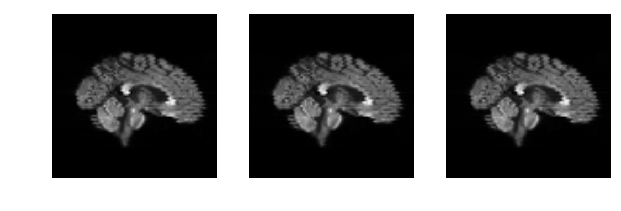

In [17]:
#View a single volume
im = 60

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(np.rot90(X_test_preprocessed[im,:,:,0]),plt.cm.get_cmap('gray'), vmin=0, vmax=1); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(np.rot90(X_test_preprocessed[im,:,:,1]),plt.cm.get_cmap('gray'), vmin=0, vmax=1); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.rot90(X_test_preprocessed[im,:,:,2]),plt.cm.get_cmap('gray'), vmin=0, vmax=1); plt.axis('off')
plt.cm.get_cmap('gray')

print('Label:',y_test[im])

## Tensorflow, GPU and notebook tests

In [13]:
#Run a simple tensorflow op
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


In [12]:
#See if GPU is available
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14673164207895695233
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 246415360
locality {
  bus_id: 1
}
incarnation: 9507612357953009496
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:04:00.0"
]


In [238]:
#Look at memory usage of all items in notebook
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('X_train_preprocessed', 1072956),
 ('variables_to_restore', 3304),
 ('probabilities', 1840),
 ('predictions', 1824),
 ('ind_true_neg', 1248),
 ('end_points', 1184),
 ('HTML', 1056),
 ('ind_false_neg', 344),
 ('ind_true_pos', 344),
 ('X_batch', 144),
 ('X_test', 144),
 ('X_train', 144),
 ('accuracy_score', 136),
 ('animate', 136),
 ('confusion_matrix', 136),
 ('create_labels', 136),
 ('fetch_data', 136),
 ('fully_connected', 136),
 ('get_batch', 136),
 ('he_init', 136),
 ('imresize', 136),
 ('imrotate', 136),
 ('pad_image', 136),
 ('plot_volumes', 136),
 ('preprocess_data_perp', 136),
 ('preprocess_data_planar', 136),
 ('preprocess_function', 136),
 ('rc', 136),
 ('train_test_split', 136),
 ('ind_false_pos', 128),
 ('test_logits', 112),
 ('train_vars', 96),
 ('y_batch', 96),
 ('y_test', 96),
 ('y_train', 96),
 ('animation', 80),
 ('exclude', 80),
 ('inception', 80),
 ('nib', 80),
 ('np', 80),
 ('plt', 80),
 ('slim', 80),
 ('tf', 80),
 ('log_dir', 79),
 ('model_name', 78),
 ('save_path